# Creating Sub-Grids from larger, familiar Ocean Grids

MOM6 needs the following INPUT files for a given run (all netcdf3):

- Ocean Horizontal Grid
- Ocean Topography/Bathymetry (with depth variable)
- Ocean Mask
- Land Mask
- Ocean Mosaic
- Land Mosaic
- Land x Ocean Mosaic
- Atmos x Land Mosaic
- Atmos x Ocean Mosaic
- Rivers File
- Ocean Vertical Grid
- grid_spec.nc (this file contains information regarding the directory locations and names of the mosaic files - this file MUST be netcdf3, just like all of the others)

In this example, we will create ocean horizontal grid + bathymetry files from larger, pre-made ocean horizontal grid + bathymetry files. These files will be used as inputs for ESMG Gridtools functions that generate Ocean/Land Mask + mosaic files. We don't need to edit Ocean Vertical Grids for this. As long as naming conventions are the same, we won't need to edit the pre-given grid_spec.nc file either. At the end, we will also create a subgrid of our pre-made rivers file.

### Define Plotting Functions

In [2]:
import cartopy 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
def plotgrid(grid, plotStep, plotproj='nearside', crs=cartopy.crs.Geodetic(), transform=cartopy.crs.Geodetic(),mapExtent=[], lon0=-50, lat0=45, title=""):
    #initiate new plot, infer projection within the plotting procedure
    plt.figure(figsize=(10,10))
    if plotproj=='nearside':
        ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
    if plotproj=='platecarree':
        ax = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    if mapExtent:
        ax.set_extent(mapExtent, crs=cartopy.crs.Geodetic())
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-90, -85, -80, -75, -70, -65, -60, -55])
    gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45, 50, 55])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #gl.xlabel_style = {'size': 15, 'color': 'gray'}
    #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

    nj = grid.dims['nyp']
    ni = grid.dims['nxp']

    iColor = 'k'
    jColor = 'k'
    iLinewidth = 1.0
    jLinewidth = 1.0
    plotAllVertices= True
    for i in range(0, ni+1, plotStep):
        if (i == 0 or i == (ni-1)) or plotAllVertices:
            if i <= ni-1:
                ax.plot(grid['x'][:,i], grid['y'][:,i], iColor, linewidth=iLinewidth, transform=transform)
    for j in range(0, nj+1, plotStep):
        if (j == 0 or j == (nj-1)) or plotAllVertices:
            if j <= nj-1:
                ax.plot(grid['x'][j,:], grid['y'][j,:], jColor, linewidth=jLinewidth, transform=transform)
    
    plt.title(title)
    
    return ax

# ideally I would use find nearest to find the indice closest to a particular value, but because this is a mesh 2d grid it doesn't work as intended
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



### Load Parent Grid

In [4]:
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# load in chassignet & xu 2017 - a 1/12th degree resolution dataset
grid = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/regional.mom6.nc")
#grid

### Visualize Pre-existing grid - 1/12th Degree 

<GeoAxesSubplot:title={'center':'ChassXu 1/12deg shown at 100x scale'}>

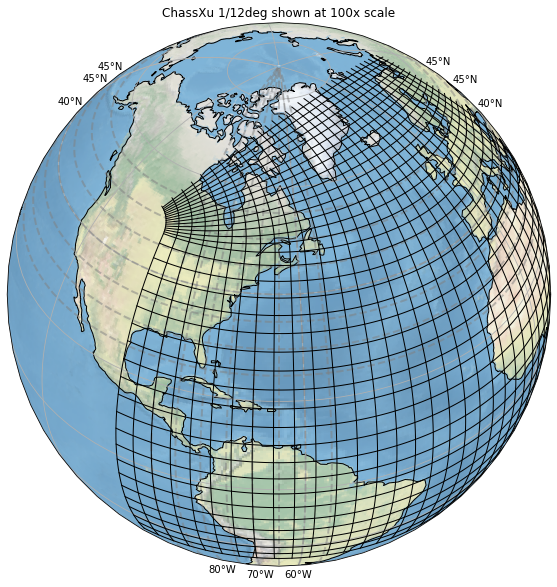

In [3]:
plotgrid(grid=grid, plotStep=100, lat0=40, lon0=-65, title="ChassXu 1/12deg shown at 100x scale")

Text(0.5, 1.0, 'NA12')

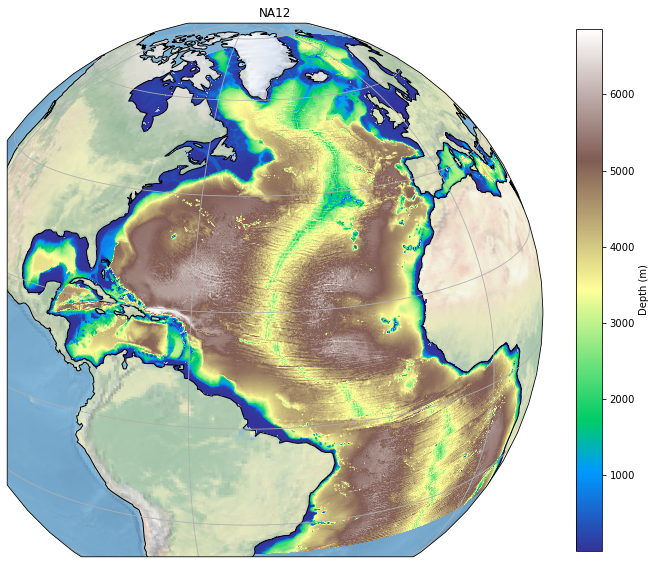

In [4]:
import cartopy.crs as crs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
layer = 'BlueMarble_NextGeneration'

topo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/depth_ATLb0.08_09m11_mom6.nc")
topo.depth.values = topo.depth.where(topo.depth!=0)
g_coarse = grid.coarsen(nxp=2, nyp=2,boundary="trim").mean()


figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.NearsidePerspective(central_latitude=20, central_longitude=-50))
ax.set_extent([-100, 30, -60,90], crs=crs.PlateCarree())
im = ax.pcolormesh(g_coarse.x.values, g_coarse.y.values, topo.depth.values, transform=crs.PlateCarree(), cmap='terrain')
ax.add_wmts(url, 'BlueMarble_NextGeneration')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.title("NA12")


# Use Index Selection to create subgrid for Regular Grid

Note that hte dataset read in above is the 1/12th supergrid. So, while it shows 1/25th degree resolution, MOM6 only solves equations for regular grid resolution (i.e., 1/12th or bathymetry read in below.) Therefore, we need to enhance our resolution using xarray interpolate which is built using scipy interpolate.

In [5]:
## ideally I would use find nearest to find the indice closest to a particular value, but because this is an irregular mesh 2d grid it doesn't work as intended
#latMinInd = find_nearest(array = grid['y'].values, value = 45)
#latMaxInd = find_nearest(array = grid['y'].values, value = 50)
#lonMinInd = find_nearest(array = grid['x'].values, value = -80)
#lonMaxInd = find_nearest(array = grid['x'].values, value = -70)

In [9]:
# v1 - southern boundary at 5 South
#latMinInd = 600
#latMaxInd = 2550
#lonMinInd = 0
#lonMaxInd = 1550


# v2 - southern boundary at 5 North - this looks like the winner
latMinInd = 1700
latMaxInd = 2050
lonMinInd = 520
lonMaxInd = 870

# test v3 - just exploring grid sizing to include lab sea
#latMinInd = 860
#latMaxInd = 3100
#lonMinInd = 0
#lonMaxInd = 1550

# test v4 - exploring grid sizing to include Baffin Bay
#latMinInd = 730
#latMaxInd = 3800
#lonMinInd = 0
#lonMaxInd = 1550

# test v5 - full north atlantic
#latMinInd = 730
#latMaxInd = 3800
#lonMinInd = 0
#lonMaxInd = 2500

#### Slice down our parent grid to our boundary

In [7]:
subgrid = grid.isel(nyp=slice(latMinInd, latMaxInd+1), nxp=slice(lonMinInd,lonMaxInd+1), ny=slice(latMinInd, latMaxInd), nx=slice(lonMinInd,lonMaxInd))
#subgrid

<GeoAxesSubplot:title={'center':'NWA12 Subgrid'}>

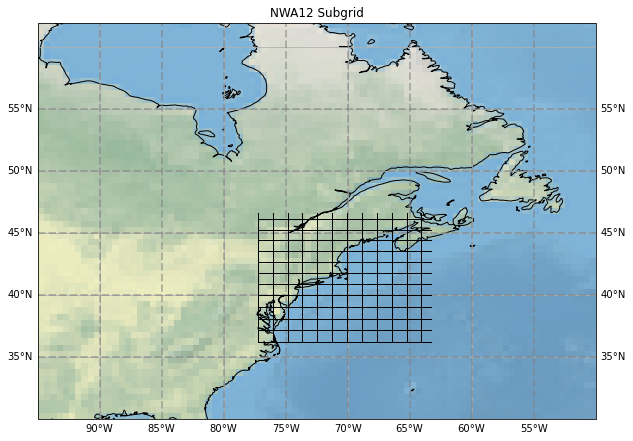

In [8]:
plotgrid(grid=subgrid, plotStep=30, plotproj='platecarree',mapExtent=[-95, -50, 30,60], title="NWA12 Subgrid")

# Quadruple Resolution from 1/12th to 1/50th

http://xarray.pydata.org/en/stable/user-guide/interpolation.html#example

In [9]:
subgrid_interp = subgrid.interp(nxp=np.linspace(subgrid.nxp[0], subgrid.nxp[-1], subgrid.dims['nxp']*2), 
                                nyp=np.linspace(subgrid.nyp[0], subgrid.nyp[-1], subgrid.dims['nyp']*2),
                                nx=np.linspace(subgrid.nx[0], subgrid.nx[-1], subgrid.dims['nx']*2), 
                                ny=np.linspace(subgrid.ny[0], subgrid.ny[-1], subgrid.dims['ny']*2))

# subgrid interp nxp and nyp values are 1 too many, so we need to shave 1 off 
subgrid_interp = subgrid_interp.isel(nyp=slice(0, len(subgrid_interp.nyp)-1), nxp=slice(0, len(subgrid_interp.nxp)-1))

# our dimensions get labeled as coordinates when we interpolate and we don't want that
subgrid_interp = subgrid_interp.drop('nxp')
subgrid_interp = subgrid_interp.drop('nyp')
subgrid_interp = subgrid_interp.drop('nx')
subgrid_interp = subgrid_interp.drop('ny')
#subgrid_interp

In [10]:
subgrid = subgrid_interp

In [11]:
subgrid_interp = subgrid.interp(nxp=np.linspace(subgrid.nxp[0], subgrid.nxp[-1], subgrid.dims['nxp']*2), 
                                nyp=np.linspace(subgrid.nyp[0], subgrid.nyp[-1], subgrid.dims['nyp']*2),
                                nx=np.linspace(subgrid.nx[0], subgrid.nx[-1], subgrid.dims['nx']*2), 
                                ny=np.linspace(subgrid.ny[0], subgrid.ny[-1], subgrid.dims['ny']*2))

# subgrid interp nxp and nyp values are 1 too many, so we need to shave 1 off 
subgrid_interp = subgrid_interp.isel(nyp=slice(0, len(subgrid_interp.nyp)-1), nxp=slice(0, len(subgrid_interp.nxp)-1))

# our dimensions get labeled as coordinates when we interpolate and we don't want that
subgrid_interp = subgrid_interp.drop('nxp')
subgrid_interp = subgrid_interp.drop('nyp')
subgrid_interp = subgrid_interp.drop('nx')
subgrid_interp = subgrid_interp.drop('ny')
#subgrid_interp

In [12]:
subgrid_interp

<xarray.Dataset>
Dimensions:   (nyp: 1401, nxp: 1401, nx: 1400, ny: 1400)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    x         (nyp, nxp) float64 -77.24 -77.23 -77.22 ... -63.29 -63.28 -63.27
    y         (nyp, nxp) float64 36.17 36.17 36.17 36.17 ... 46.61 46.61 46.61
    angle_dx  (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dx        (nyp, nx) float64 3.593e+03 3.593e+03 ... 3.059e+03 3.059e+03
    dy        (ny, nxp) float64 3.595e+03 3.595e+03 ... 3.058e+03 3.058e+03
    area      (ny, nx) float64 1.291e+07 1.292e+07 ... 9.354e+06 9.354e+06
    tile      |S255 b'tile1'
Attributes:
    history:  grid_hycom2mom6

#### Make sure there are no accidental NaNs that crept in when we interpolated

In [13]:
np.count_nonzero(np.isnan(subgrid_interp.x.values))

0

<GeoAxesSubplot:title={'center':'NWA50 Supergrid - 1400*1400'}>

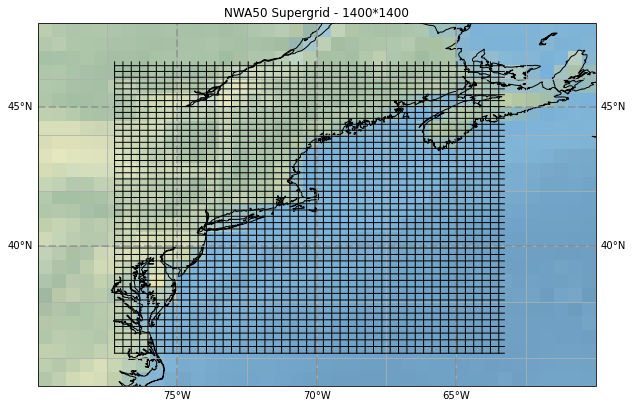

In [14]:
plotgrid(grid=subgrid_interp, plotStep=30, plotproj='platecarree',mapExtent=[-80, -60, 35,48], title="NWA50 Supergrid - 1400*1400")

In [96]:
# save the netcdf file
subgrid_interp.to_netcdf("/Users/james/Downloads/nwa50_interped.nc", format='NETCDF3_64BIT')

In [5]:
test = xr.open_dataset("/Users/james/Downloads/nwa50_interped.nc")
#test

<GeoAxesSubplot:>

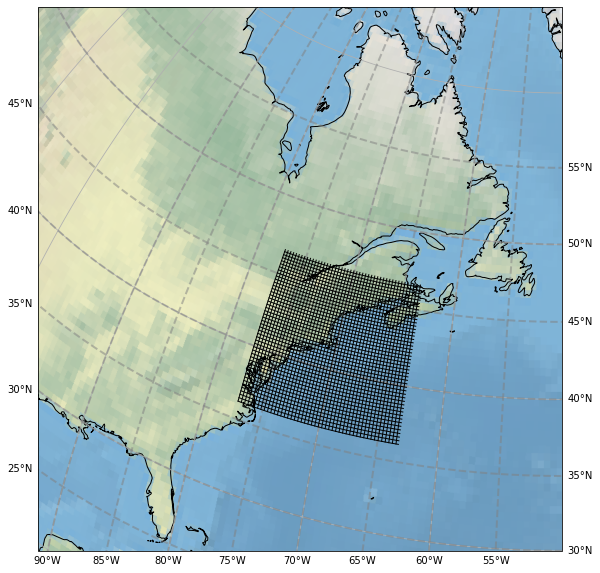

In [6]:
plotgrid(grid=test, plotStep=30, mapExtent=[-95, -50, 30,60])

# What percentage of the grid is land?

In [10]:
land = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/land_mask.nc")
subland = land.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))

# 1 is land, 0 is ocean
unique, counts = np.unique(subland.mask, return_counts=True)
print(unique,counts)

[0. 1.] [16797 13828]


In [11]:
print("{0:.00%}".format(counts[1] / ( counts[1] +counts[0])))

45%


# Load Bathymetry and Interpolate

In [12]:
topo = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/depth_ATLb0.08_09m11_mom6.nc")
#topo

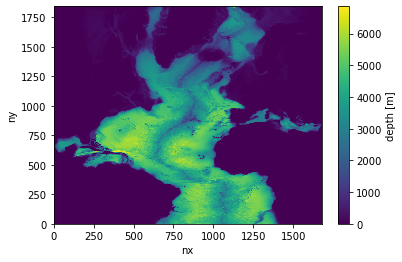

In [13]:
topo.depth.plot()

In [14]:
subtopo = topo.isel(ny=slice(int(latMinInd/2), int(latMaxInd/2)), nx=slice(int(lonMinInd/2),int(lonMaxInd/2)))
subtopo

<xarray.Dataset>
Dimensions:  (nx: 175, ny: 175)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float32 ...
    wet      (ny, nx) float32 ...
Attributes:
    comment:  depth_GLBb0.08_09m11 subregioned to ATLb0.08 via isuba_topog | ...
    history:  topo_2mom6

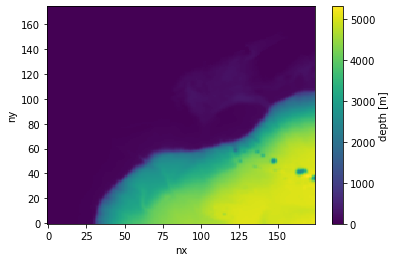

In [15]:
subtopo.depth.plot()

In [16]:
subtopo_interp = subtopo.interp(nx=np.linspace(subtopo.nx[0], subtopo.nx[-1], subtopo.dims['nx']*2), 
                                ny=np.linspace(subtopo.ny[0], subtopo.ny[-1], subtopo.dims['ny']*2))
subtopo_interp

<xarray.Dataset>
Dimensions:  (nx: 350, ny: 350)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 ... 30.93 32.21 33.72 35.22
    wet      (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    nx       (nx) float64 0.0 0.4986 0.9971 1.496 ... 172.5 173.0 173.5 174.0
    ny       (ny) float64 0.0 0.4986 0.9971 1.496 ... 172.5 173.0 173.5 174.0
Attributes:
    comment:  depth_GLBb0.08_09m11 subregioned to ATLb0.08 via isuba_topog | ...
    history:  topo_2mom6

In [17]:
subtopo_interp = subtopo_interp.drop('nx')
subtopo_interp = subtopo_interp.drop('ny')

In [18]:
subtopo_interp.dims['nx']*2

700

In [19]:
subtopo_interp2 = subtopo_interp.interp(nx=np.linspace(subtopo_interp.nx[0], subtopo_interp.nx[-1], subtopo_interp.dims['nx']*2), 
                                ny=np.linspace(subtopo_interp.ny[0], subtopo_interp.ny[-1], subtopo_interp.dims['ny']*2))

#need to drop the coordinates that get added when we inteprolate
subtopo_interp2 = subtopo_interp2.drop('nx')
subtopo_interp2 = subtopo_interp2.drop('ny')
#subtopo_interp

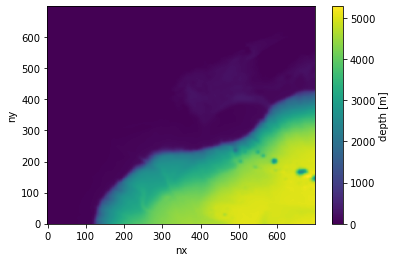

In [20]:
subtopo_interp2.depth.plot()

In [21]:
print(np.count_nonzero(np.isnan(subtopo.depth.values)), np.count_nonzero(np.isnan(subtopo_interp.depth.values)))

0 0


In [22]:
subtopo_interp2

<xarray.Dataset>
Dimensions:  (nx: 700, ny: 700)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 ... 32.97 33.72 34.47 35.22
    wet      (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    comment:  depth_GLBb0.08_09m11 subregioned to ATLb0.08 via isuba_topog | ...
    history:  topo_2mom6

Text(0.5, 1.0, 'NWA50 Bathymetry - 700*700')

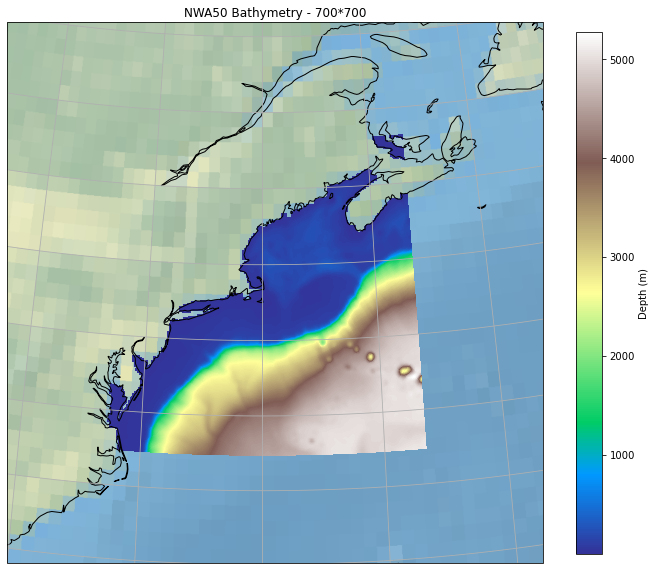

In [58]:
sg = subgrid_interp.coarsen(nxp=2, nyp=2,boundary="trim").mean()

#subtopo_interp.depth.values = subtopo_interp.depth.where(subtopo_interp['depth'].values > 0.01,np.nan)
import cartopy.crs as crs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
#subtopo.depth.values = subtopo.depth.where(subtopo.depth!=0)

figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.NearsidePerspective(central_latitude=45, central_longitude=290))
ax.set_extent([-80, -59, 32,50], crs=crs.PlateCarree())
im = ax.pcolormesh(sg.x.values, sg.y.values, subtopo_interp2.depth.where(subtopo_interp2['depth'].values > 0.01,np.nan), transform=crs.PlateCarree(), cmap='terrain')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
ax.stock_img()
ax.coastlines()
ax.gridlines()
plt.title("NWA50 Bathymetry - 700*700")

Text(0.5, 1.0, 'NWA50 Bathymetry - 700*700')

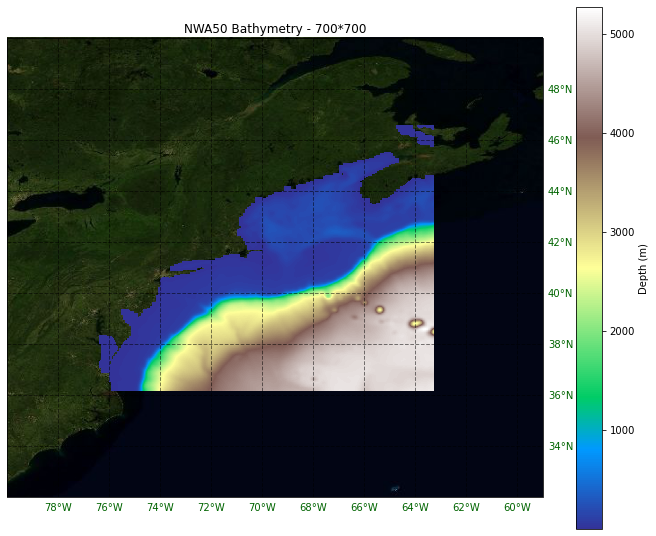

In [67]:
pngDir = "/Users/james/Documents/Github/nwa25/misc/images/"
img = plt.imread(f'{pngDir}bluemarble.png')
img_extent = (-180, 180, -90, 90)
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.imshow(img, origin='upper', extent=img_extent, transform=crs.PlateCarree(), vmin=0,vmax=255)
ax.set_extent([-80, -59, 32,50], crs=crs.PlateCarree())
im = ax.pcolormesh(sg.x.values, sg.y.values, subtopo_interp2.depth.where(subtopo_interp2['depth'].values > 0.01,np.nan), transform=crs.PlateCarree(), cmap='terrain')
ax.add_wmts(url, 'BlueMarble_NextGeneration')
plt.colorbar(im, label="Depth (m)", shrink=0.8)
gl = ax.gridlines(crs=crs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.left_labels = False
gl.right_labels=True
gl.bottom_labels=True
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([-80,-78, -76, -74, -72,-70,-68, -66, -64, -62, -60, -58, -56])
gl.ylocator = mticker.FixedLocator([32, 34, 36, 38, 40, 42, 44, 46, 48, 50])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'darkgreen', 'weight': 'normal'}
gl.ylabel_style = {'color': 'darkgreen', 'weight': 'normal'}
plt.title("NWA50 Bathymetry - 700*700")


In [23]:
subtopo_interp2

<xarray.Dataset>
Dimensions:  (nx: 700, ny: 700)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 ... 32.97 33.72 34.47 35.22
    wet      (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    comment:  depth_GLBb0.08_09m11 subregioned to ATLb0.08 via isuba_topog | ...
    history:  topo_2mom6

# Mosaic Files

These files are necessary for MOM6 information exchange between land/atmos/ocean

In [24]:
import sys, os, logging, cartopy
from gridtools.gridutils import GridUtils

inputDir = "/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa50/"

# Initialize a grid object
grd = GridUtils()
grd.openGrid("/Users/james/Downloads/nwa50_interped.nc", gridType='MOM6')
grd.readGrid()


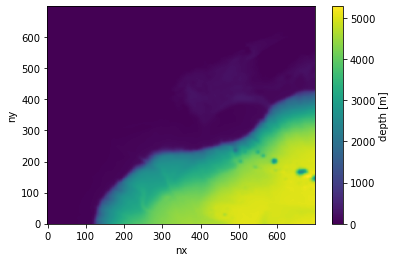

In [25]:
subtopo_interp2['depth'].plot()

In [84]:
subtopo_interp['depth']

<xarray.DataArray 'depth' (ny: 350, nx: 350)>
array([[   0.        ,    0.        ,    0.        , ..., 5094.26153407,
        5093.97451704, 5093.6875    ],
       [   0.        ,    0.        ,    0.        , ..., 5090.47482688,
        5090.61467436, 5090.75452185],
       [   0.        ,    0.        ,    0.        , ..., 5086.68811969,
        5087.25483169, 5087.8215437 ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,   21.89206042,
          25.50923925,   29.12641808],
       [   0.        ,    0.        ,    0.        , ...,   27.051836  ,
          29.61236451,   32.17289303],
       [   0.        ,    0.        ,    0.        , ...,   32.21161158,
          33.71548978,   35.21936798]])
Dimensions without coordinates: ny, nx
Attributes:
    units:        m
    description:  topographic depth at T-cell centers

In [82]:
np.asarray(subtopo_interp2['depth'])

array([[   0.        ,    0.        ,    0.        , ..., 5093.97410642,
        5093.83080321, 5093.6875    ],
       [   0.        ,    0.        ,    0.        , ..., 5092.29689331,
        5092.26000111, 5092.22310891],
       [   0.        ,    0.        ,    0.        , ..., 5090.6196802 ,
        5090.68919901, 5090.75871781],
       ...,
       [   0.        ,    0.        ,    0.        , ...,   29.62189548,
          30.89957342,   32.17725137],
       [   0.        ,    0.        ,    0.        , ...,   31.66976836,
          32.68403902,   33.69830967],
       [   0.        ,    0.        ,    0.        , ...,   33.71764125,
          34.46850462,   35.21936798]])

In [26]:
# Write out FMS related support files
grd.makeSoloMosaic(
    topographyGrid=subtopo_interp2.depth,
    writeLandmask=True,
    writeOceanmask=True,
    inputDirectory=inputDir,
    overwrite=True,
)
grd.saveGrid(filename=os.path.join(inputDir, "ocean_hgrid.nc"))


Successfully wrote netCDF file to /Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa50/ocean_hgrid.nc


# Edit Dtype on Land/Ocean Mask and fill Hudson Bay as land cells

In [27]:
land_mask = xr.open_dataset(inputDir + "land_mask.nc")

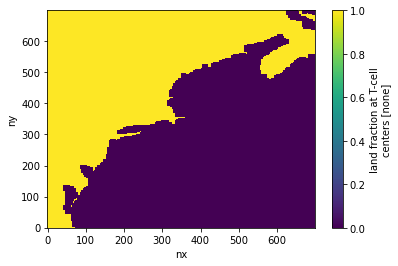

In [28]:
land_mask.mask.plot()

In [64]:
# Mask Out Hudson Bay
hudson = land_mask
for y in range(1500,len(hudson.ny)):
    for x in range(400,600):
        if y > 1500 and x < 600:
            hudson.mask[y,x] = 1.0

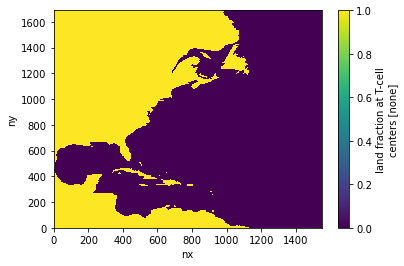

In [65]:
hudson.mask.plot()

In [29]:
land_mask.to_netcdf(inputDir + "land_mask.nc", mode='w', format='NETCDF3_64BIT')

In [30]:
ocean_mask = xr.open_dataset(inputDir + "ocean_mask.nc")
#ocean_mask.mask

In [31]:
ocean_mask["mask"] = ocean_mask.mask.astype('double')

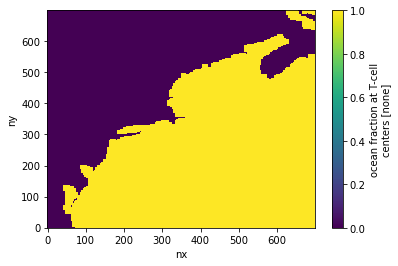

In [32]:
ocean_mask.mask.plot()

In [33]:
ocean_mask.to_netcdf(inputDir + "ocean_mask.nc", mode='w', format='NETCDF3_64BIT')

# Convert all files to netcdf3

MOM6 currently takes netcdf3 files - not netcdf4

In [28]:
import xarray as xr
from os import listdir
from os.path import isfile, join
myPath = "/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/"
fileList = [f for f in listdir(myPath) if isfile(join(myPath, f))]
#fileList.remove('land_mask.nc')
fileList.remove('soda3.3.1_5dy_ocean_reg_2010_01_05.nc')
fileList

['vgrid_75_2m.nc',
 '.DS_Store',
 'sss_mom6.nc',
 'land_mosaic_tile1Xocean_mosaic_tile1.nc',
 'mosaic.nc',
 'atmos_mosaic_tile1Xocean_mosaic_tile1.nc',
 'ocean_mask.nc',
 'grid_spec.nc',
 'atmos_mosaic_tile1Xland_mosaic_tile1.nc',
 'ocean_mosaic.nc',
 'ocean_hgrid.nc',
 'vgrid_41_2m.nc',
 'land_mask.nc',
 'README.md',
 'ocean_topog.nc']

In [29]:

for f in fileList:
    if f.endswith('.nc'):
        print(f)
        tem = xr.open_dataset(myPath + f)
        tem.to_netcdf(path=str(myPath + 'netcdf3/' + f), format='NETCDF3_CLASSIC')

vgrid_75_2m.nc
sss_mom6.nc
land_mosaic_tile1Xocean_mosaic_tile1.nc
mosaic.nc
atmos_mosaic_tile1Xocean_mosaic_tile1.nc
ocean_mask.nc
grid_spec.nc
atmos_mosaic_tile1Xland_mosaic_tile1.nc
ocean_mosaic.nc
ocean_hgrid.nc
vgrid_41_2m.nc
land_mask.nc
ocean_topog.nc


# Create Rivers File

In [34]:
import xarray as xr
import numpy as np
riv = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/chassxu/09m11/rivers_09m11_mom6.nc")
#riv

In [22]:
# v2 - southern boundary at 5 North - this looks like the winner
latMinInd = 860
latMaxInd = 2550
lonMinInd = 0
lonMaxInd = 1550

subriv = riv.isel(Y=slice(int(latMinInd/2), int(latMaxInd/2)), X=slice(int(lonMinInd/2),int(lonMaxInd/2)))
#subriv

In [23]:
subriv_interp = subriv.interp(X=np.linspace(subriv.X[0], subriv.X[-1], subriv.dims['X']*2), 
                                Y=np.linspace(subriv.Y[0], subriv.Y[-1], subriv.dims['Y']*2))

#need to drop the coordinates that get added when we inteprolate
#subriv = subtopo_interp.drop('nx')
#subriv = subtopo_interp.drop('ny')
#subriv

In [2]:
#subriv_interp

In [22]:
inputDir = "/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/"

In [23]:
subriv_interp.to_netcdf(inputDir + "netcdf3/rivers.nc", mode='w', format='NETCDF3_64BIT')

In [31]:
b = xr.open_dataset(str(myPath + 'netcdf3/' + 'ocean_topog.nc'))

In [32]:
b

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690)
Dimensions without coordinates: nx, ny
Data variables:
    depth    (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  ESMG/gridtools: ['heads/main-0-gf0335a3582-dirty', '']
    history:       2022-01-21: gridtools.grid.mom6.convert_ROMS_to_MOM6 + kwargs

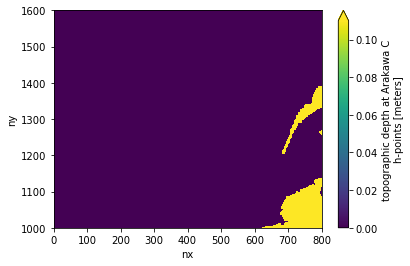

In [40]:
b.depth.plot(vmax=0.11, xlim=(0,800), ylim=(1000,1600))